In [1]:
from importlib import reload
import IntersectionDataset
reload(IntersectionDataset)
from IntersectionDataset import IntersectionDataset2

from torch.utils.data import DataLoader
import multiprocessing
from torchvision.transforms import ToTensor
import torch
import glob
import os
import cv2
import json
import numpy as np

import matplotlib.pyplot as plt

In [5]:
intersections = glob.glob('dataset/test/intersection_*')
intersections

['dataset/test/intersection_001',
 'dataset/test/intersection_002',
 'dataset/test/intersection_003',
 'dataset/test/intersection_004',
 'dataset/test/intersection_005',
 'dataset/test/intersection_006',
 'dataset/test/intersection_007',
 'dataset/test/intersection_008',
 'dataset/test/intersection_009',
 'dataset/test/intersection_010',
 'dataset/test/intersection_011',
 'dataset/test/intersection_012',
 'dataset/test/intersection_013',
 'dataset/test/intersection_014',
 'dataset/test/intersection_015',
 'dataset/test/intersection_016',
 'dataset/test/intersection_017',
 'dataset/test/intersection_018',
 'dataset/test/intersection_019',
 'dataset/test/intersection_020',
 'dataset/test/intersection_021',
 'dataset/test/intersection_022',
 'dataset/test/intersection_023',
 'dataset/test/intersection_024',
 'dataset/test/intersection_025',
 'dataset/test/intersection_026',
 'dataset/test/intersection_027',
 'dataset/test/intersection_028',
 'dataset/test/intersection_029',
 'dataset/test

In [33]:
def map_exit_to_class(exit_x, exit_y):
    if exit_y == 0:
        return 1  # left
    elif exit_y == 399:
        return 2  # right
    elif exit_x == 0:
        return 3  # ahead
    else:
        raise ValueError("Unexpected exit position")


In [34]:
for i, intersection in enumerate(intersections):
    satellite = os.path.join(intersection, 'satellite.png')
    paths = glob.glob(f"{intersection}/paths/*")
    paths_png = [os.path.join(paths[i], f"path_line.png") for i in range(len(paths))]
    paths_img = [cv2.imread(paths_png[i], cv2.IMREAD_GRAYSCALE) for i in range(len(paths_png))]
    ee_dirs = [os.path.join(paths[i], f"path_line_ee.json") for i in range(len(paths))]
    ee_data = []
    for ee_dir in ee_dirs:
        with open(ee_dir) as f:
            ee_data.append(json.load(f))

    
    H, W = paths_img[0].shape

    combined = torch.full((1, H, W), 0, dtype=torch.long)

    for j, p in enumerate(paths_img):
        ee = ee_data[j]
        exit_x = ee["exit"]["x"]
        exit_y = ee["exit"]["y"]
        
        class_label = map_exit_to_class(exit_x, exit_y)
        
        p = cv2.GaussianBlur(p, (5, 5), 0)
        
        mask = torch.from_numpy(p > 0)
        
        class_label = torch.full((1, H, W), class_label, dtype=torch.long)
        
        combined += mask * class_label
    combined = combined.clamp(0, 4)

    combined_img = combined.squeeze().numpy()
    
    np.save(f"{intersection}/class_labels.npy", combined_img)
    print(f"Saved {intersection}/class_labels.npy")

Saved dataset/test/intersection_001/class_labels.npy
Saved dataset/test/intersection_002/class_labels.npy
Saved dataset/test/intersection_003/class_labels.npy
Saved dataset/test/intersection_004/class_labels.npy
Saved dataset/test/intersection_005/class_labels.npy
Saved dataset/test/intersection_006/class_labels.npy
Saved dataset/test/intersection_007/class_labels.npy
Saved dataset/test/intersection_008/class_labels.npy
Saved dataset/test/intersection_009/class_labels.npy
Saved dataset/test/intersection_010/class_labels.npy
Saved dataset/test/intersection_011/class_labels.npy
Saved dataset/test/intersection_012/class_labels.npy
Saved dataset/test/intersection_013/class_labels.npy
Saved dataset/test/intersection_014/class_labels.npy
Saved dataset/test/intersection_015/class_labels.npy
Saved dataset/test/intersection_016/class_labels.npy
Saved dataset/test/intersection_017/class_labels.npy
Saved dataset/test/intersection_018/class_labels.npy
Saved dataset/test/intersection_019/class_labe

(np.float64(-0.5), np.float64(399.5), np.float64(399.5), np.float64(-0.5))

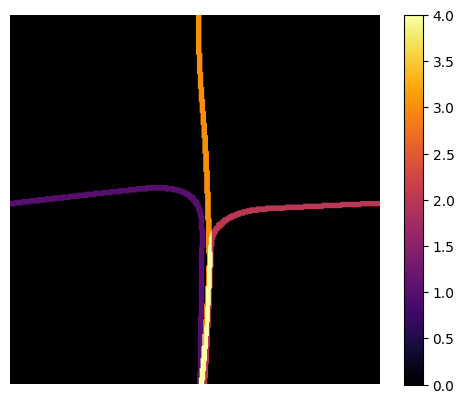

In [3]:
img = np.load(f"dataset/test/intersection_032/class_labels.npy")
plt.imshow(img, cmap="inferno")
plt.colorbar()
plt.axis('off')

In [12]:
# find percentage of each class
for i, intersection in enumerate(intersections):
    img = np.load(f"{intersection}/class_labels.npy")
    unique, counts = np.unique(img, return_counts=True)
    percentages = np.round((counts / counts.sum()) * 100, 2)
    class_counts = {int(k): {'count': int(v), 'percentage': float(p)} for k, v, p in zip(unique, counts, percentages)}
    print(f"Intersection {i}: {class_counts}")

Intersection 0: {0: {'count': 154614, 'percentage': 96.63}, 1: {'count': 1649, 'percentage': 1.03}, 2: {'count': 1066, 'percentage': 0.67}, 3: {'count': 1159, 'percentage': 0.72}, 4: {'count': 1512, 'percentage': 0.94}}
Intersection 1: {0: {'count': 156190, 'percentage': 97.62}, 1: {'count': 1412, 'percentage': 0.88}, 3: {'count': 1346, 'percentage': 0.84}, 4: {'count': 1052, 'percentage': 0.66}}
Intersection 2: {0: {'count': 155097, 'percentage': 96.94}, 1: {'count': 2506, 'percentage': 1.57}, 3: {'count': 2397, 'percentage': 1.5}}
Intersection 3: {0: {'count': 156190, 'percentage': 97.62}, 2: {'count': 1405, 'percentage': 0.88}, 3: {'count': 1433, 'percentage': 0.9}, 4: {'count': 972, 'percentage': 0.61}}
Intersection 4: {0: {'count': 155752, 'percentage': 97.34}, 1: {'count': 1804, 'percentage': 1.13}, 2: {'count': 1411, 'percentage': 0.88}, 3: {'count': 1033, 'percentage': 0.65}}
Intersection 5: {0: {'count': 155012, 'percentage': 96.88}, 1: {'count': 1328, 'percentage': 0.83}, 2: 